In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

# Domain

In [2]:
points = np.array([[-1, -1], 
                   [-1, 1], 
                   [1, -1], 
                   [1, 1], 
                   [-1/2, -1/2], 
                   [-1/2, 1/2], 
                   [1/2, -1/2], 
                   [1/2, 1/2]])*np.pi/2

In [3]:
seg = np.array([[0, 1], [1, 3], [3, 2], [2, 0],
                [4, 5], [5, 7], [7, 6], [6, 4.0]])
holes = np.array([[0.0, 0.0]])

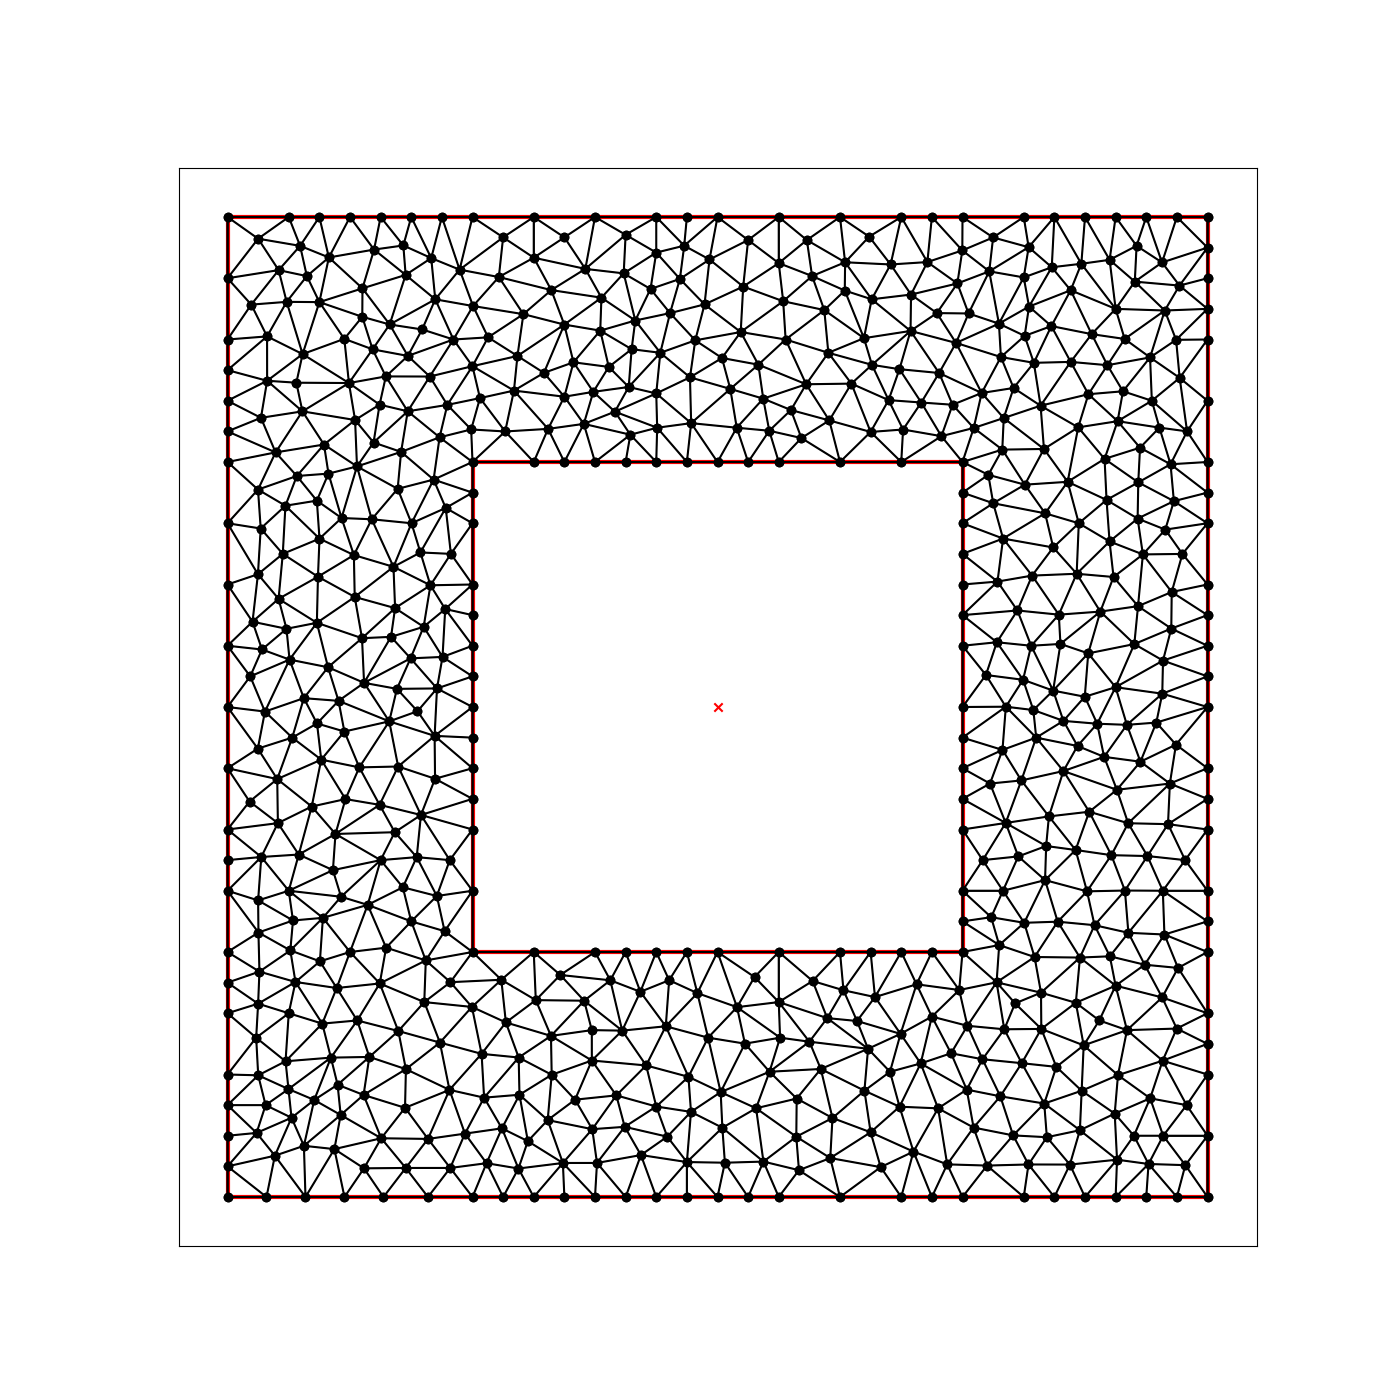

In [18]:
cndt = triangulate({"vertices":points, "segments":seg, "holes":holes}, opts="Rpa0.01q30ne")
plt.figure(figsize=(14, 14))
ax = plt.subplot(111, aspect='equal')
tplot(ax, **cndt, )

In [30]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [31]:
tx = np.linspace(-2, 2, 200)
ty = np.linspace(-2, 2, 200)
xx, yy = np.meshgrid(tx, ty, indexing="xy")
points_ = np.stack((xx, yy)).transpose(1, 2, 0)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [32]:
a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

indices = np.where(np.isclose((area1+area2+area3).transpose(1, 2, 0), areas[None, None, ...]))

## Get boundary points

In [33]:
is_boundary_point = np.zeros(points.shape[0], dtype=bool)

In [34]:
for index, element in enumerate(triangles):
    
    if (neighbours[index] == -1).sum() == 2:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element] = True
    elif (neighbours[index] == -1).sum() == 1:
        indices_ = np.where(neighbours[index] != -1)[0]
        is_boundary_point[element[indices_]] = True

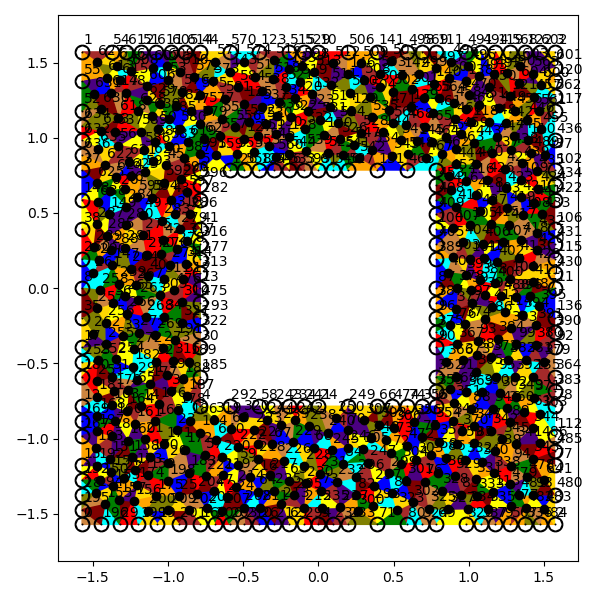

In [35]:
colors = ["red", "blue", "green", "yellow", "cyan", "brown", "orange", "olive", "gold", "indigo", "peru", "maroon"]
l = len(colors)
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("equal")


for index, triangle in enumerate(triangles_s):
    t1 = plt.Polygon(triangle, color=colors[index%l])
    plt.gca().add_patch(t1)

for idx, point in enumerate(points):
    ax.text(x=point[0]+0.01, y=point[1]+0.05, s=f"{idx}", fontsize=10)
    
for idx, point in enumerate(points):
    if is_boundary_point[idx]:
        ax.scatter(point[0], point[1], color="black", lw=10, s=2)
    else:
        ax.scatter(point[0], point[1], color="black")
fig.tight_layout()
plt.show()

In [36]:
matrix = np.zeros((points.shape[0], points.shape[0]), dtype=np.float64)
b = np.zeros(points.shape[0])

for idx, element in enumerate(triangles):
        
    if is_boundary_point[element[0]] == True:
        matrix[element[0], element[0]] = 1
        b[element[0]] = 0
    else:

        matrix[element[0], element[0]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[0], element[1]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[0], element[2]] += 2 * (points[element[1], 1] - points[element[2], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[0], element[0]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[0], element[1]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[0], element[2]] += 2 * (points[element[1], 0] - points[element[2], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]

        b[element[0]] -= 2 * areas[idx] / 3

    if is_boundary_point[element[1]] == True:
        matrix[element[1], element[1]] = 1
        b[element[1]] *= 0
    else:

        matrix[element[1], element[0]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[1], element[1]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[1], element[2]] += 2 * (points[element[2], 1] - points[element[0], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[1], element[0]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[1], element[1]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[1], element[2]] += 2 * (points[element[2], 0] - points[element[0], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]

        b[element[1]] -= 2 * areas[idx] / 3

    if is_boundary_point[element[2]] == True:
        matrix[element[2], element[2]] = 1
        b[element[2]] *= 0
    else:
        
        matrix[element[2], element[0]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[1], 1] - points[element[2], 1]) / areas[idx]
        matrix[element[2], element[1]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[2], 1] - points[element[0], 1]) / areas[idx]
        matrix[element[2], element[2]] += 2 * (points[element[0], 1] - points[element[1], 1])*(points[element[0], 1] - points[element[1], 1]) / areas[idx]

        matrix[element[2], element[0]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[1], 0] - points[element[2], 0]) / areas[idx]
        matrix[element[2], element[1]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[2], 0] - points[element[0], 0]) / areas[idx]
        matrix[element[2], element[2]] += 2 * (points[element[0], 0] - points[element[1], 0])*(points[element[0], 0] - points[element[1], 0]) / areas[idx]
    
        b[element[2]] -= 2 * areas[idx] / 3

In [37]:
c = np.linalg.solve(matrix, b)

In [38]:
S = np.zeros(xx.shape)
for j in range(3):
    nom = np.abs(np.linalg.det(np.concatenate((np.ones((indices[0].shape[0], 3, 1)), np.concatenate((triangles_s[indices[-1]][:, np.arange(3)!=j, :], points_[indices[:-1]][:, None]), axis=1)), axis=-1)))
    S[indices[:-1]] += c[triangles][indices[-1]][:,j] * nom / areas[indices[-1]]

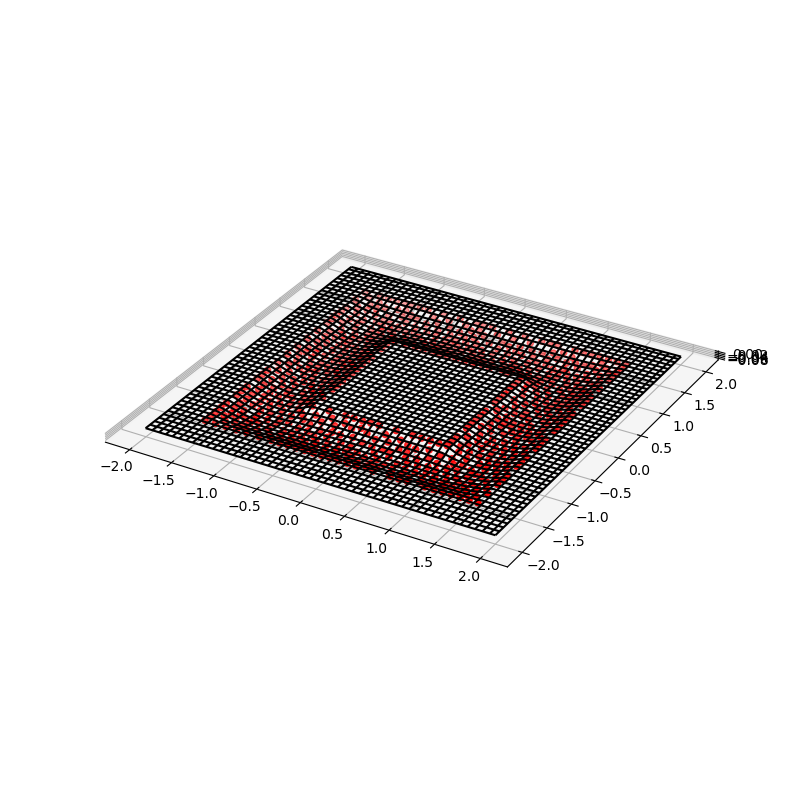

In [39]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
# ax.plot_surface(xx, yy, S, color='blue')
ax.plot_wireframe(xx, yy, S, color="black")
ax.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(c)))
ax.scatter(points[:, 0], points[:, 1], c, color="red")
plt.show()

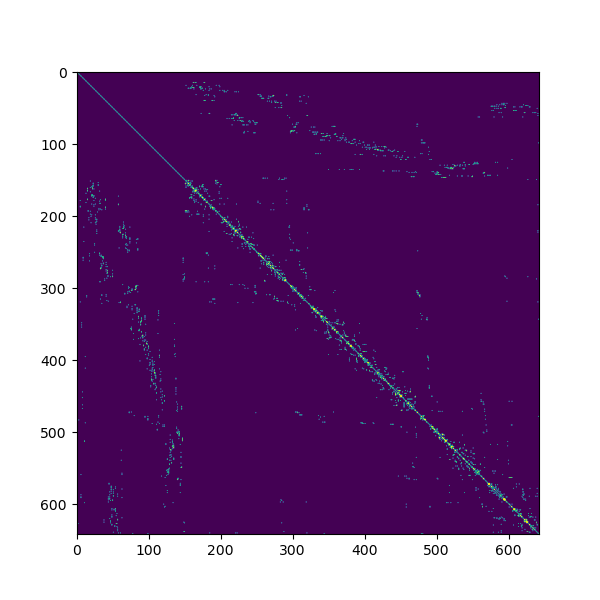

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(matrix != 0)